In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Titanic.csv


# Первый взгляд

In [2]:
df = pd.read_csv('/kaggle/input/Titanic.csv')

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
# Уберем ненужные столбцы. Очевидно, что ID, имя и номер билета мало способствуют шансу на выживание.
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

In [5]:
# Посмотрим на данные еще раз
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


# Аналитика

In [6]:
# Посмотрим на общую статистику выживаемости
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Видно, что погибших гораздо больше, чем выживших

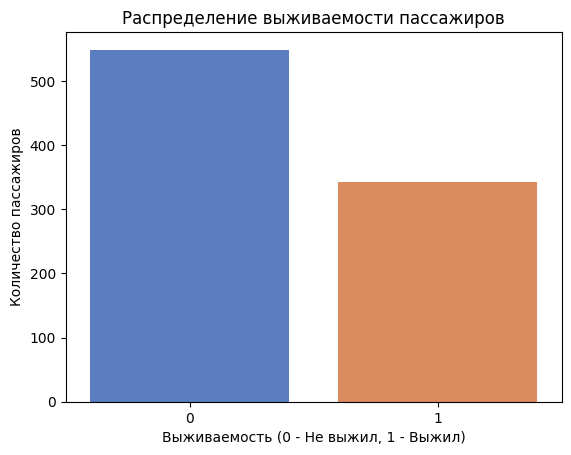

In [7]:
sns.countplot(x='Survived', data=df, palette='muted')
plt.title('Распределение выживаемости пассажиров')
plt.xlabel('Выживаемость (0 - Не выжил, 1 - Выжил)')
plt.ylabel('Количество пассажиров')
plt.show()

In [8]:
# Посмотрим на статистику выживаемости в зависимости от пола.
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


Женщины выживали чаще, чем мужчины. Это можно связать с тем, что на шлюпки в первую очередь  пропускали женщин и детей.

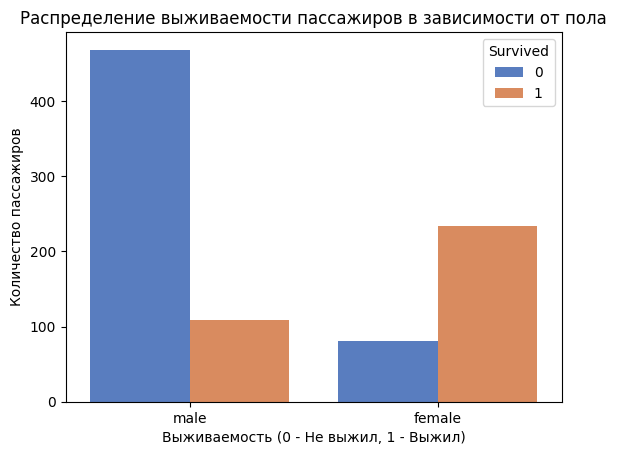

In [9]:
sns.countplot(data=df, x='Sex', hue='Survived', palette='muted')
plt.title('Распределение выживаемости пассажиров в зависимости от пола')
plt.xlabel('Выживаемость (0 - Не выжил, 1 - Выжил)')
plt.ylabel('Количество пассажиров')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


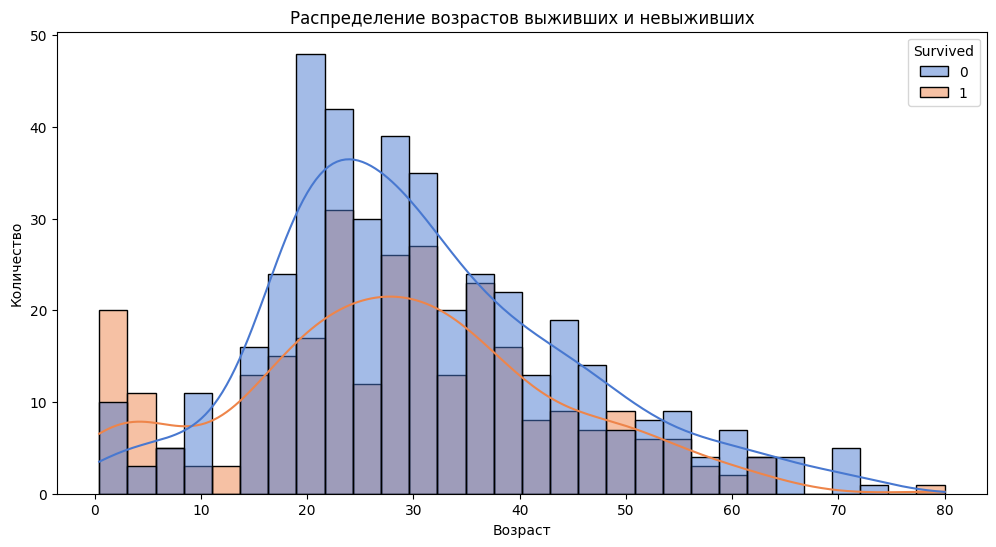

In [10]:
# Посмотрим на распределение возрастов в зависимости от выживаемости
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, palette='muted')
plt.title('Распределение возрастов выживших и невыживших')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Заметно, что есть выброс в диапазоне малолетних детей. Вероятно, они были с родителями, которые помогли им спастись.

In [11]:
# Посмотрим на статистику выживаемости в зависимости от класса
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Можно сделать вывод, что люди с более высоким классом выживали чаще, чем другие. Это можно связать с расположением кают, возможно, их близостью к выходу.

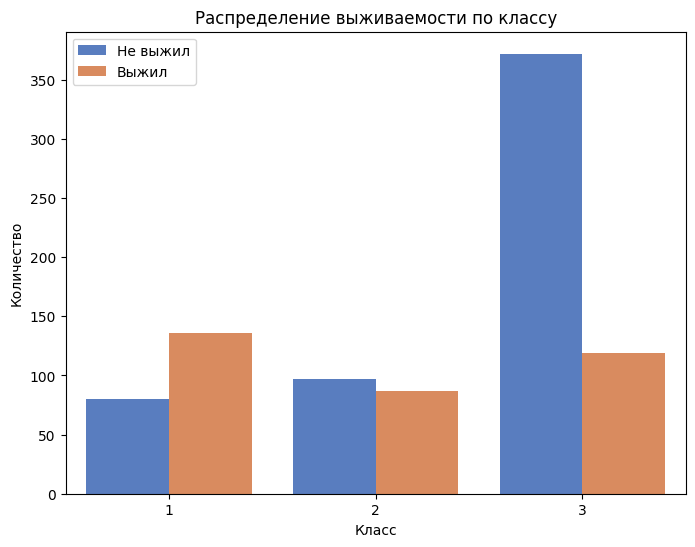

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Pclass', hue='Survived', palette='muted')
plt.title('Распределение выживаемости по классу')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.legend(['Не выжил', 'Выжил'])
plt.show()

In [13]:
# Посмотрим на статистику выживаемости в зависимости от размера семьи.

# Создание признака размера семьи
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # +1 для учета самого пассажира

# Создание признака одинокий пассажир или нет
df['IsAlone'] = 1  
df.loc[df['FamilySize'] > 1, 'IsAlone'] = 0

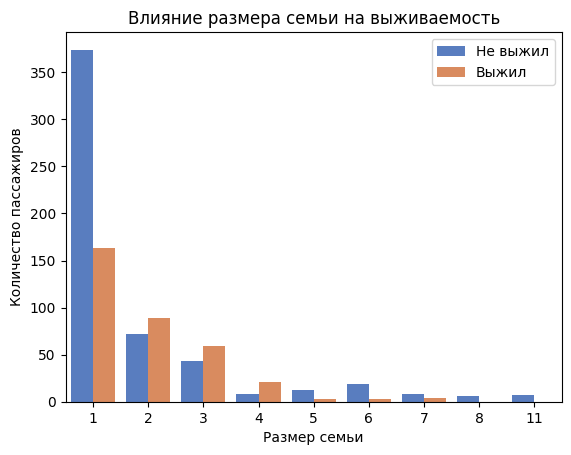

In [14]:
sns.countplot(x='FamilySize', hue='Survived', data=df, palette='muted')
plt.title('Влияние размера семьи на выживаемость')
plt.xlabel('Размер семьи')
plt.ylabel('Количество пассажиров')
plt.legend(['Не выжил', 'Выжил'])
plt.show()

Видно, что люди с маленькими семьями выживали чаще. Это можно связать с тем, что им нужно было меньше думать о том, что нужно спасать еще и других помимо себя. Но и смертность среди них выше.

In [15]:
# Посмотрим на статистику выживаемости в зависимости от типа каюты

# Извлечение типа каюты (первая буква)
df['CabinType'] = df['Cabin'].str.extract(r'([A-Za-z])')

cabin_survival = df.groupby('CabinType')['Survived'].mean().reset_index()

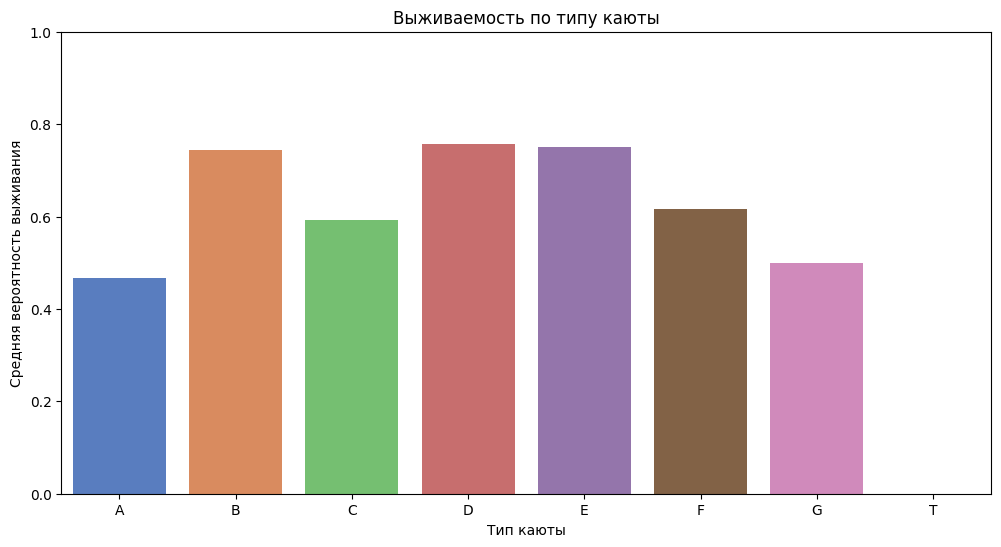

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(data=cabin_survival, x='CabinType', y='Survived', palette='muted')
plt.title('Выживаемость по типу каюты')
plt.ylabel('Средняя вероятность выживания')
plt.xlabel('Тип каюты')
plt.ylim(0, 1)  # Ограничиваем ось Y от 0 до 1
plt.show()

Сначала было непонятно, почему график получился настолько неинформативным. Но потом я увидела, что в колонке Cabin слишком много пропусков, что и могло повлиять на статистику

# Подготовка датасета

In [17]:
df.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Cabin         687
Embarked        2
FamilySize      0
IsAlone         0
CabinType     687
dtype: int64

In [18]:
# Избавляемся от ненужных колонок из-за большого количества пропусков
df.drop(columns=['Cabin', 'CabinType'], inplace=True)

In [19]:
# Заполним недостающие значения возраста медианой
df['Age'] = df['Age'].fillna(df['Age'].median())

In [20]:
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [21]:
#Заполним недостающие значения самым частовстречающимся
df['Embarked'] = df['Embarked'].fillna('S')

In [22]:
# Создадим признак ценовой категории билета
df['FareBand'] = pd.qcut(df['Fare'], 3, labels=['Low', 'Medium', 'High'])
# Создадим признак возрастной категории пассажиров
df['AgeBand'] = pd.cut(df['Age'], bins=[0, 18, 35, 60, 100], labels=['Child', 'Adult', 'Senior', 'Elderly'])

In [23]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
IsAlone       0
FareBand      0
AgeBand       0
dtype: int64

In [24]:
# Посмотрим категориальные данные

categorical_columns = [] 
numeric_columns = [] 

for column_name in df.columns:
    if (df[column_name].dtypes == 'object') or (df[column_name].dtypes.name == 'category'):
        categorical_columns += [column_name] 
    else:
        numeric_columns += [column_name] 

categorical_columns

['Sex', 'Embarked', 'FareBand', 'AgeBand']

In [25]:
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df_encoded.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,FareBand_Medium,FareBand_High,AgeBand_Adult,AgeBand_Senior,AgeBand_Elderly
Survived,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307,0.016639,-0.203367,-0.543351,0.003650,-0.149683,0.026914,0.253865,-0.077053,0.017590,-0.051224
Pclass,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500,0.065997,0.135207,0.131900,0.221009,0.074053,0.138163,-0.693683,0.199842,-0.299461,-0.136667
Age,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688,-0.245619,0.171647,0.081163,-0.031415,-0.006729,-0.072407,0.137107,-0.216849,0.629250,0.448281
SibSp,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651,0.890712,-0.584471,-0.114631,-0.026354,0.068734,-0.016605,0.313142,-0.132663,-0.073854,-0.055819
Parch,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225,0.783111,-0.583398,-0.245489,-0.081228,0.060814,-0.008635,0.329872,-0.270643,0.069374,-0.021502
Fare,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000,0.217138,-0.271832,-0.182333,-0.117216,-0.162184,-0.221490,0.587822,-0.119664,0.128482,0.029368
FamilySize,0.016639,0.065997,-0.245619,0.890712,0.783111,0.217138,1.000000,-0.690922,-0.200988,-0.058592,0.077359,-0.015663,0.378821,-0.225880,-0.015819,-0.048892
IsAlone,-0.203367,0.135207,0.171647,-0.584471,-0.583398,-0.271832,-0.690922,1.000000,0.303646,0.086464,0.029074,-0.149938,-0.345029,0.255478,-0.063932,0.070067
Sex_male,-0.543351,0.131900,0.081163,-0.114631,-0.245489,-0.182333,-0.200988,0.303646,1.000000,-0.074115,0.119224,-0.138160,-0.134980,0.074542,-0.007270,0.071958
Embarked_Q,0.003650,0.221009,-0.031415,-0.026354,-0.081228,-0.117216,-0.058592,0.086464,-0.074115,1.000000,-0.499421,-0.075912,-0.156969,0.128565,-0.114494,0.002542


# Моделирование

In [26]:
X = df.drop(columns=['Survived'])
y = df['Survived']

In [27]:
# Train-test split
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],))) 
# model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5446 - loss: 0.9406 - val_accuracy: 0.6783 - val_loss: 0.8731
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6460 - loss: 0.8784 - val_accuracy: 0.7063 - val_loss: 0.8310
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6348 - loss: 0.8424 - val_accuracy: 0.7343 - val_loss: 0.7922
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6808 - loss: 0.8114 - val_accuracy: 0.7413 - val_loss: 0.7590
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6758 - loss: 0.7751 - val_accuracy: 0.7413 - val_loss: 0.7253
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7088 - loss: 0.7319 - val_accuracy: 0.7203 - val_loss: 0.6961
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7356 - loss: 0.6916 - val_accuracy: 0.7063 - val_loss: 0.6673
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7622 - loss: 0.6873 - val_accuracy: 0.7273 - val_loss: 0.6390
Ep

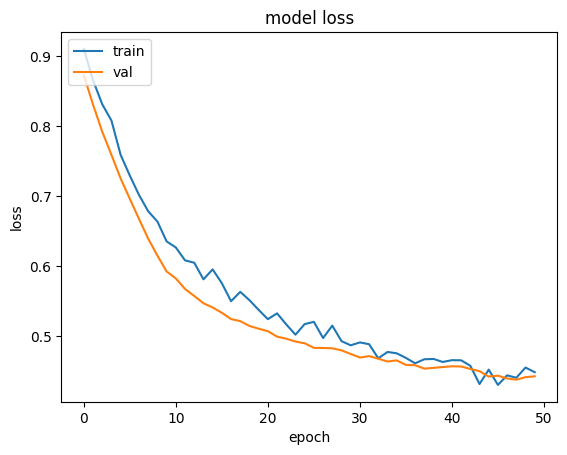

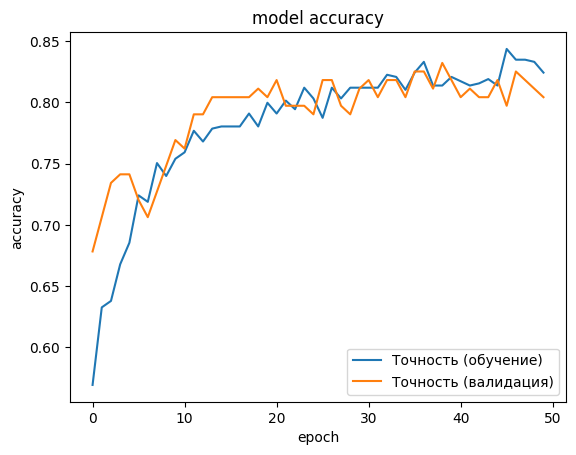

In [28]:
# Построим график потерь loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Построим график точности accuracy на обучающей и валидационной выборках
plt.plot(history.history['accuracy'], label='Точность (обучение)')
plt.plot(history.history['val_accuracy'], label='Точность (валидация)')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5229 - loss: 1.1057 - val_accuracy: 0.7063 - val_loss: 1.0528
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6008 - loss: 1.0698 - val_accuracy: 0.6853 - val_loss: 1.0086
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6367 - loss: 1.0101 - val_accuracy: 0.6853 - val_loss: 0.9650
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5617 - loss: 1.0035 - val_accuracy: 0.6713 - val_loss: 0.9261
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6010 - loss: 0.9630 - val_accuracy: 0.6713 - val_loss: 0.8850
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5958 - loss: 0.9110 - val_accuracy: 0.6713 - val_loss: 0.8458
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5987 - loss: 0.9061 - val_accuracy: 0.6783 - val_loss: 0.8162
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6109 - loss: 0.8812 - val_accuracy: 0.6993 - val_loss: 0.7876
Epoch 9/100

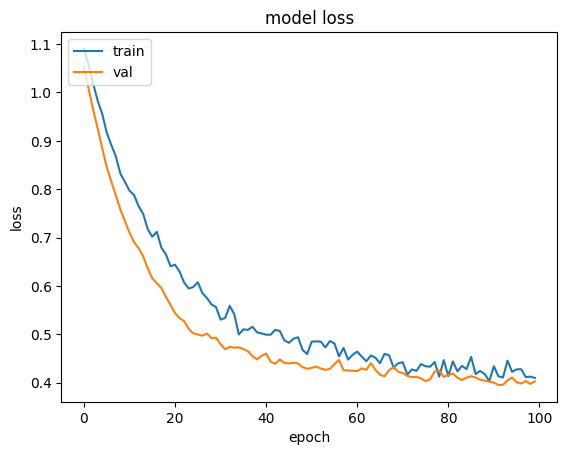

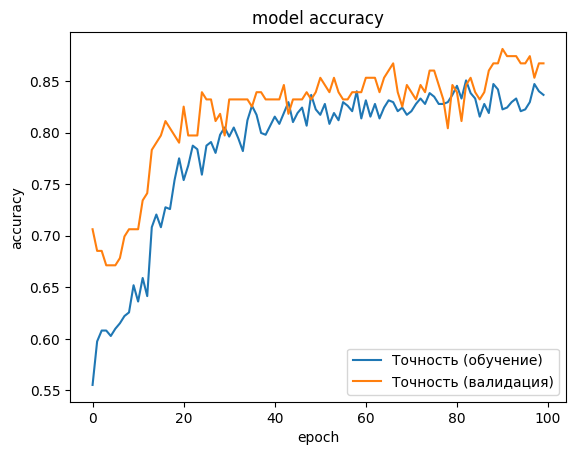

In [30]:
# Построим график потерь loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Построим график точности accuracy на обучающей и валидационной выборках
plt.plot(history.history['accuracy'], label='Точность (обучение)')
plt.plot(history.history['val_accuracy'], label='Точность (валидация)')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Наилучший результат попеременно у двух моделей - 0.84

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 1 accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       105
           1       0.85      0.72      0.78        74

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179





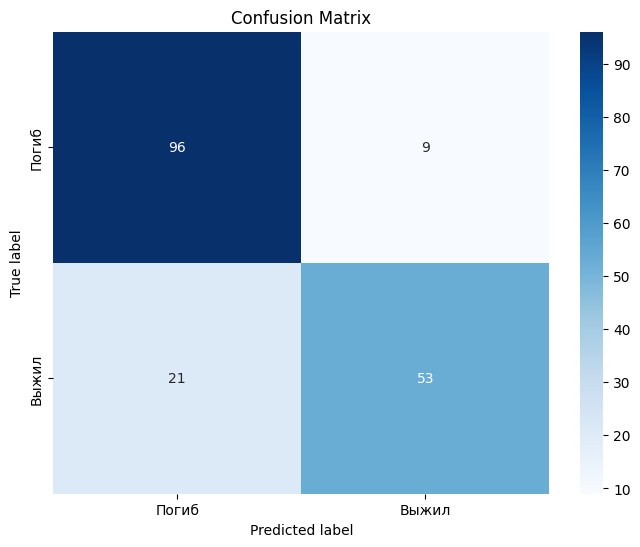

Модель предсказала, что человек погиб, и в реальности он тоже погиб =  96
Модель предсказала, что человек погиб, но в реальности он выжил =  21
Модель предсказала, что человек выжил, но в реальности он погиб =  9
Модель предсказала, что человек выжил, и в реальности он тоже выжил =  53


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 2 accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       111
           1       0.74      0.64      0.69        67

    accuracy                           0.78       178
   macro avg       0.77      0.75      0.76       178
weighted avg       0.78      0.78      0.78       178





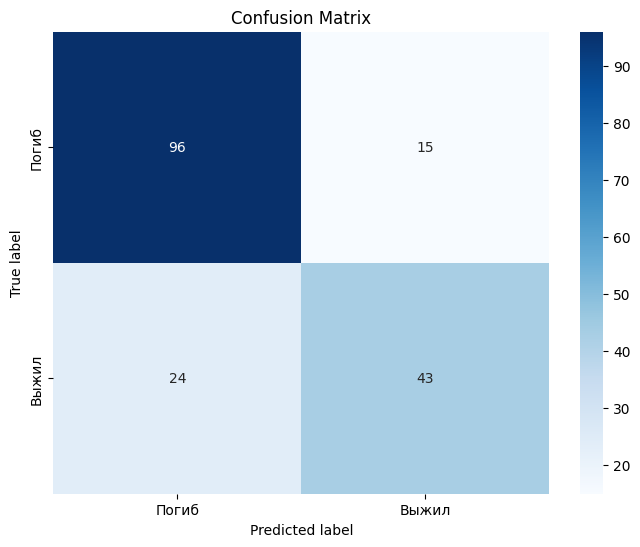

Модель предсказала, что человек погиб, и в реальности он тоже погиб =  96
Модель предсказала, что человек погиб, но в реальности он выжил =  24
Модель предсказала, что человек выжил, но в реальности он погиб =  15
Модель предсказала, что человек выжил, и в реальности он тоже выжил =  43


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 3 accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       108
           1       0.88      0.80      0.84        70

    accuracy                           0.88       178
   macro avg       0.88      0.86      0.87       178
weighted avg       0.88      0.88      0.88       178





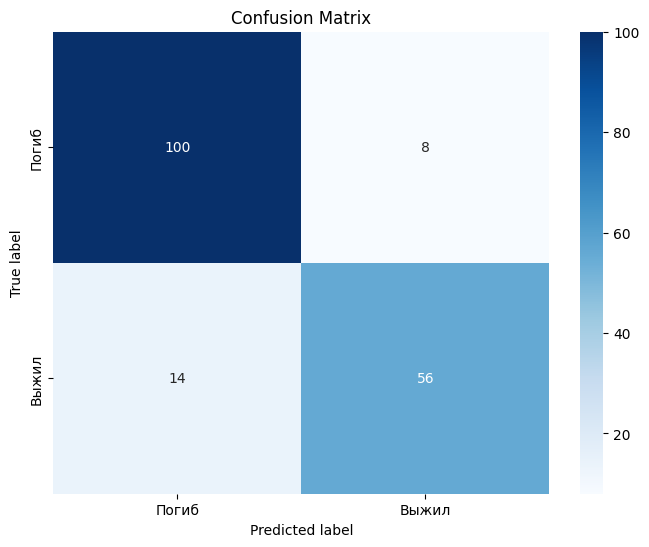

Модель предсказала, что человек погиб, и в реальности он тоже погиб =  100
Модель предсказала, что человек погиб, но в реальности он выжил =  14
Модель предсказала, что человек выжил, но в реальности он погиб =  8
Модель предсказала, что человек выжил, и в реальности он тоже выжил =  56


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 4 accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       112
           1       0.73      0.71      0.72        66

    accuracy                           0.80       178
   macro avg       0.78      0.78      0.78       178
weighted avg       0.80      0.80      0.80       178





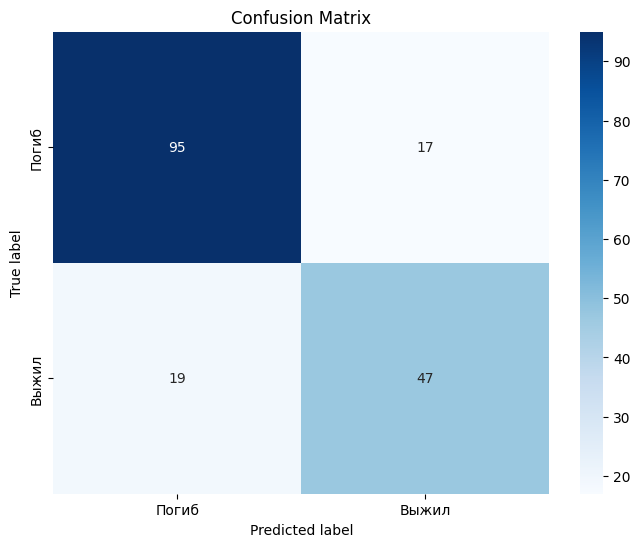

Модель предсказала, что человек погиб, и в реальности он тоже погиб =  95
Модель предсказала, что человек погиб, но в реальности он выжил =  19
Модель предсказала, что человек выжил, но в реальности он погиб =  17
Модель предсказала, что человек выжил, и в реальности он тоже выжил =  47


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 5 accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       113
           1       0.79      0.71      0.75        65

    accuracy                           0.83       178
   macro avg       0.82      0.80      0.81       178
weighted avg       0.82      0.83      0.82       178





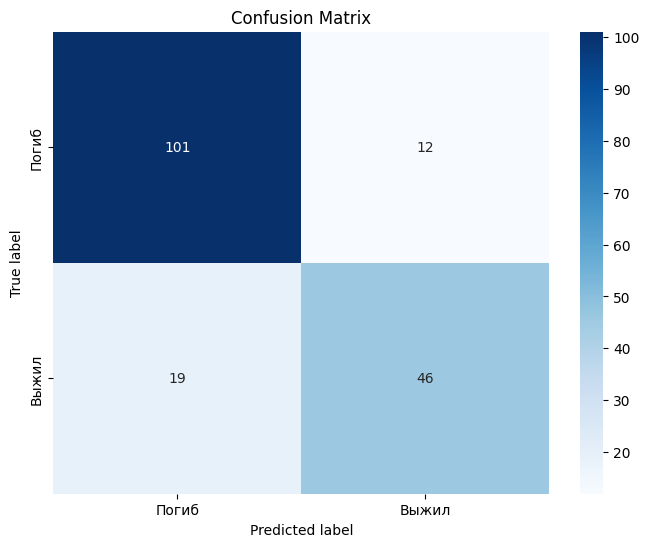

Модель предсказала, что человек погиб, и в реальности он тоже погиб =  101
Модель предсказала, что человек погиб, но в реальности он выжил =  19
Модель предсказала, что человек выжил, но в реальности он погиб =  12
Модель предсказала, что человек выжил, и в реальности он тоже выжил =  46


Mean accuracy: 0.82


In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

# Параметры кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Скалирование данных
scaler = StandardScaler()

# Функция для создания модели
def create_model(input_shape):
    # 1 модель
#     model = Sequential()
#     model.add(Input(shape=(input_shape,)))
#     model.add(Input(shape=(input_shape,)))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
#     model.add(Dropout(0.5))
#     model.add(Dense(8, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # 2 модель
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Списки для хранения результатов
accuracies = []

# Функция для отображения матрицы ошибок
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Цикл по фолдам кросс-валидации
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Создаем и обучаем модель
    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)
    
    # Оцениваем модель
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Преобразуем вероятности в метки классов
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Печатаем результаты для текущего фолда
    print(f'Fold {fold + 1} accuracy: {accuracy:.2f}')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    
    # Генерация и отображение матрицы ошибок
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Погиб', 'Выжил'])  # Замените названия классов по необходимости
    print("Модель предсказала, что человек погиб, и в реальности он тоже погиб = ", cm[0, 0])
    print("Модель предсказала, что человек погиб, но в реальности он выжил = ", cm[1, 0])
    print("Модель предсказала, что человек выжил, но в реальности он погиб = ", cm[0, 1])
    print("Модель предсказала, что человек выжил, и в реальности он тоже выжил = ", cm[1, 1])
    print("\n")

# Средняя точность по всем фолдам
print(f'Mean accuracy: {np.mean(accuracies):.2f}')


Лучший результат кросс-валидации - 0.83


# Вывод о проделанной работе

В рамках данного проекта была проведена работа, основными этапами которой являются:
* Анализ данных, составлении стастистики и поиск закономерностей
* Обработка данных и feature engineering
* Построение модели машинного обучения для предсказания выживаемости пассажиров на борту Titanic 

Были проанализированы характеристики датасета, на основе которых были построены **следующие графики**:
1. Распределение выживаемости пассажиров
1. Распределение выживаемости пассажиров в зависимости от пола
1. Распределение возрастов выживших и невыживших
1. Распределение выживаемости по классу
1. Влияние размера семьи на выживаемость
1. Выживаемость по типу каюты

Выполнена предобработка данных, включая обработку пропусков и преобразование категориальных признаков в числовые, а также сделаны выводы, которые помогли при дальнейшем feature engineering. Были созданы **следующие признаки**:
* AgeBand - возрастная категория пассажира
* FareBand - ценовая категория билета пассажира
* IsAlone - одинокий ли пассажир
* FamilySize - размер семьи пассажира

Построены матрицы ошибок и графики классификации, что дало возможность визуализировать производительность модели и понять, где она ошибается.

**Заключение**

В результате проделанной работы была разработана модель, способная предсказывать выживаемость пассажиров Titanic. Графики и визуализации оказались полезными для понимания данных и проверки гипотез.